In [1]:
!pip install prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore')

### On cherche à travers ce notebook de réaliser une analyse de la série temporelle des montants d'achat pour les transactions d'approvisionnement effectuées par Monoprix France

In [3]:
import pyodbc
conn = pyodbc.connect('DRIVER={SQL Server};'
                      'SERVER=DESKTOP-7QR5TL6;'
                      'DATABASE=SA_SAP_Fico;'
                      'Trusted_Connection=yes')  #Khaleha kenek testaamel windows authentification fel ssms snn zid USERNAME = '<username>'
#                                                                                                                     # PASSWORD = '<password>

In [ ]:
query = """
    SELECT
        [TransactionDate],
        [Amount],
        [PaymentMethod]
    FROM [dbo].[SA_Sales_Transactions]
    WHERE [TransactionDate] IS NOT NULL
    ORDER BY [TransactionDate]
    """

    df = pd.read_sql(query, conn)
    print(f" {len(df)} transactions chargées avec succès")

 7000 transactions chargées avec succès


In [5]:
# df = pd.read_csv("/content/TransactionSP (1).csv", sep= ";")

In [6]:
df.head()

,TransactionDate,Amount,PaymentMethod
0,2019-07-26,3107.0,Espèces
1,2019-07-26,3436.0,Carte
2,2019-07-26,2869.0,Carte
3,2019-07-27,377.0,Espèces
4,2019-07-27,4748.0,Espèces


On définit la colonne TransactionDate comme type 'DateTime' et comme index

In [7]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df = df.set_index('TransactionDate').sort_index()

In [8]:
df.head()

,Amount,PaymentMethod
TransactionDate,,
2019-07-26,3107.0,Espèces
2019-07-26,3436.0,Carte
2019-07-26,2869.0,Carte
2019-07-27,377.0,Espèces
2019-07-27,4748.0,Espèces


In [9]:
# df["Amount"].replace(",",".")

De meme, on définit la colonne Amount comme float pour réaliser des oppperations d'aggrégation

In [11]:
df["Amount"] = df["Amount"].astype(str).str.replace(",", ".").astype(float)


In [12]:
df.head()

,Amount,PaymentMethod
TransactionDate,,
2019-07-26,3107.0,Espèces
2019-07-26,3436.0,Carte
2019-07-26,2869.0,Carte
2019-07-27,377.0,Espèces
2019-07-27,4748.0,Espèces


On enlève la colonne PaymentMethod

In [13]:
df = df.drop(columns='PaymentMethod')

### Finalement, Pour obtenir la somme des transactions journalières, On groupe les données par date et on effectue la somme

In [14]:
daily_sales = df.groupby(['TransactionDate'])['Amount'].sum().reset_index()

In [15]:
daily_sales.head()

,TransactionDate,Amount
0,2019-07-26,9412.0
1,2019-07-27,5125.0
2,2019-07-28,7363.0
3,2019-07-29,9391.0
4,2019-07-30,6274.0


In [16]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1948 entries, 0 to 1947
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionDate  1948 non-null   datetime64[ns]
 1   Amount           1948 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 30.6 KB


In [17]:
daily_sales.index = daily_sales.index.astype(str)

In [18]:
daily_sales.head()

,TransactionDate,Amount
0,2019-07-26,9412.0
1,2019-07-27,5125.0
2,2019-07-28,7363.0
3,2019-07-29,9391.0
4,2019-07-30,6274.0


### On Utilise un boxplot pour voir les données abbérantes de la colonne "Amount". Toutes les valeurs abbérantes existent après le upperbound (Q3 + 1.5 * IQR)

<Axes: xlabel='Amount'>

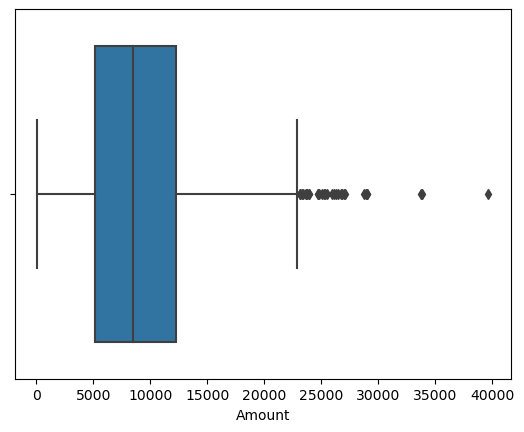

In [19]:
sns.boxplot(x=daily_sales['Amount'])

### Pour enlever les valeurs abérrantes, et spécificement pour notre cas ou elles sont nombreuses, on fera recours à la winsorization. La winsorisation est le processus de remplacement des valeurs extrêmes des données statistiques afin de limiter l'effet des valeurs aberrantes sur les calculs ou les résultats obtenus en utilisant ces données.

In [20]:
from scipy.stats.mstats import winsorize

### On définit cette fonction afin de detecter que les colonnes qui présentent des valeurs abérrantes. Rappelant que ces valeurs ce situent au-dessous du lower bound (Q1Q1 - 1.5 * IQR) et le Au-dessus du upperbound (Q3 + 1.5 * IQR)

In [21]:
def detect_outliers_iqr(df, columns):
    outlier_columns = []
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        if df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0] > 0:
            outlier_columns.append(col)
    return outlier_columns

In [22]:
numeric_columns = daily_sales.select_dtypes(include=[np.number]).columns
outlier_columns = detect_outliers_iqr(daily_sales, numeric_columns)

On réalise la winsorization des données avec les limites 0,1 dans les deux cotés. Cela indique que :

Les 10 % de valeurs les plus basses (inférieures au 10e percentile) sont remplacées par la valeur correspondant au 10e percentile.

Les 10 % de valeurs les plus élevées (supérieures au 90e percentile) sont remplacées par la valeur correspondant au 90e percentile.

Au lieu de supprimer des points de données, la winsorisation limite les valeurs extrêmes, conservant ainsi le même nombre d'observations tout en rendant l'ensemble de données plus résistant aux valeurs aberrantes.

In [23]:
def winsorize_outliers(df, outlier_columns, limits=(0.1, 0.1)):

    for col in outlier_columns:
        df[col] = winsorize(df[col], limits=limits)
    return df

In [24]:
df_cleaned = winsorize_outliers(daily_sales, outlier_columns)

### Après winsorization, on note la disparition totale des valeurs abérantes.

<Axes: xlabel='Amount'>

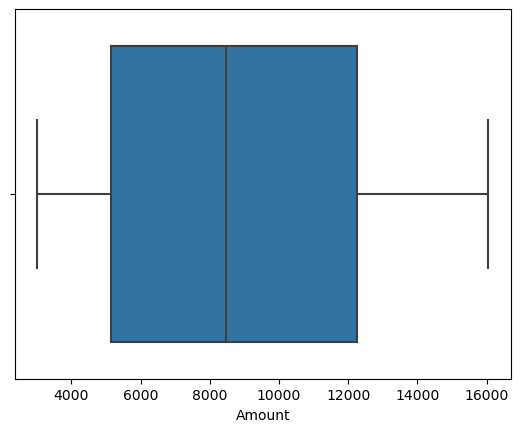

In [25]:
sns.boxplot(x=daily_sales['Amount'])

On passe à l'analyse de l'asymétrie des données ou on a obtenu un skew de 0.25 qui est très proche de 0.

Cela indique une très légère asymétrie positive :

La queue de la distribution est un peu étirée vers la droite (vers les valeurs plus grandes: **Voir Histogramme au dessous**).

Mais l'effet est très faible (0,25 est petit).

In [26]:
df_cleaned.skew(numeric_only=True)

Amount    0.255975
dtype: float64

<Axes: xlabel='Amount', ylabel='Count'>

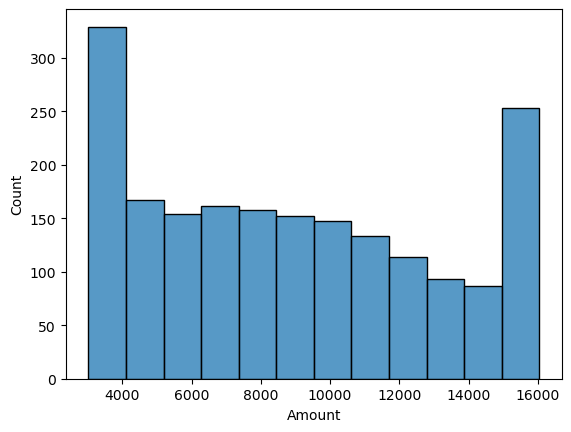

In [27]:
sns.histplot(df_cleaned['Amount'])

In [28]:
# df_cleaned['Amount'] = np.log1p(daily_sales['Amount'])

In [29]:
# from scipy.stats import boxcox
# df_cleaned['Amount'], _ = boxcox(daily_sales['Amount'])

Malgré que la valeur de l'asymétrie est petite, on essai de la rapprocher de 0 avec la méthod yeo-johnson car toutes nos valeurs sont positives.

In [30]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

In [31]:
df_cleaned['Amount'] = pt.fit_transform(df_cleaned[['Amount']])

In [32]:
df_cleaned.skew(numeric_only=True)

Amount   -0.09384
dtype: float64

In [33]:
# df_cleaned.skew(numeric_only=True) ------ for boxcox

In [34]:
# sns.histplot(df_cleaned['Amount']) --------- for boxcox

<Axes: xlabel='Amount', ylabel='Count'>

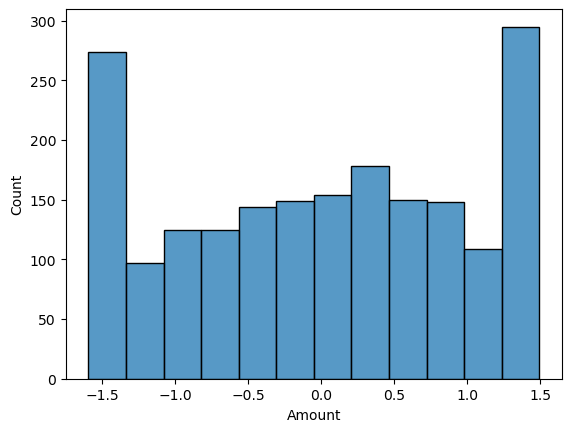

In [35]:
sns.histplot(df_cleaned['Amount'])

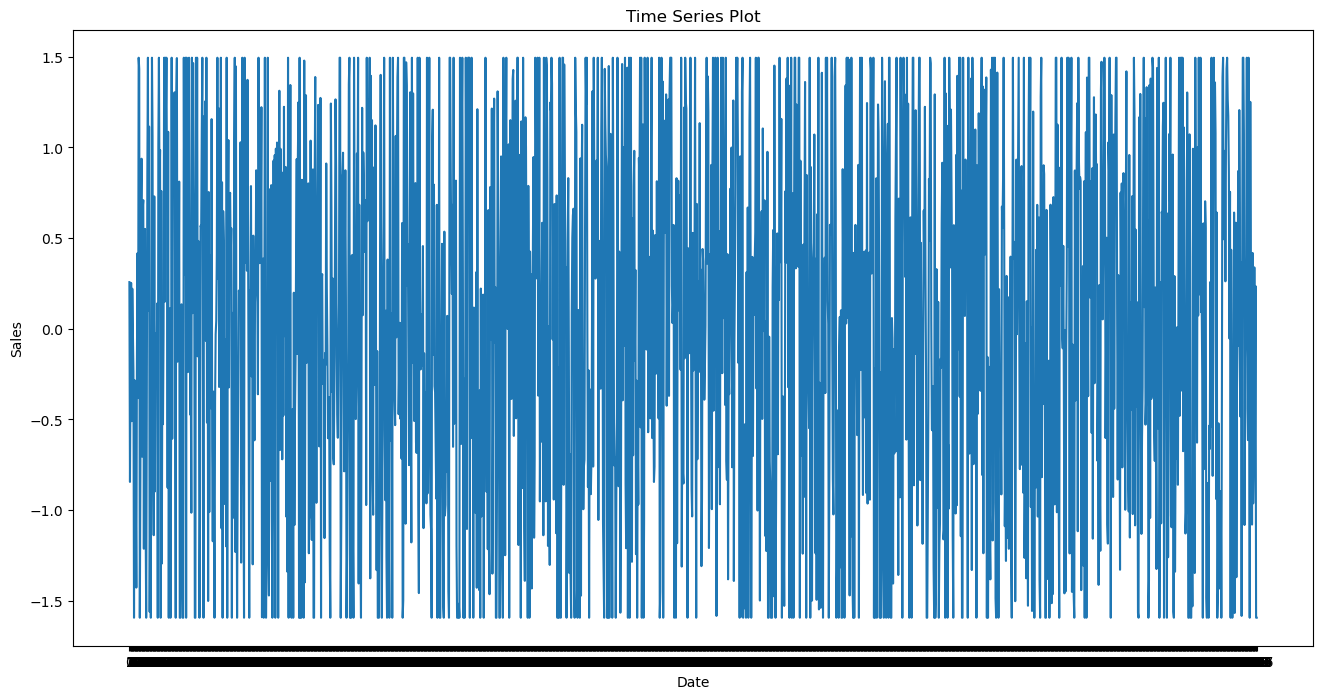

In [36]:
plt.figure(figsize=(16, 8))
plt.plot(df_cleaned['Amount'])
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

On visualise la décomposition saisonniaire de notre série temporelle. On peut constater que La composante de tendance présente une certaine variation, mais pas explosive, ce qui pourrait indiquer une certaine non-stationnarité.

La composante saisonnière est plate, donc sans tendance saisonnière (vous avez raison de définir seasonal=False).

Les résidus apparaissent centrés autour de 0, relativement homoscédastiques, et sans tendance évidente, ce qui est idéal pour la modélisation ARIMA.

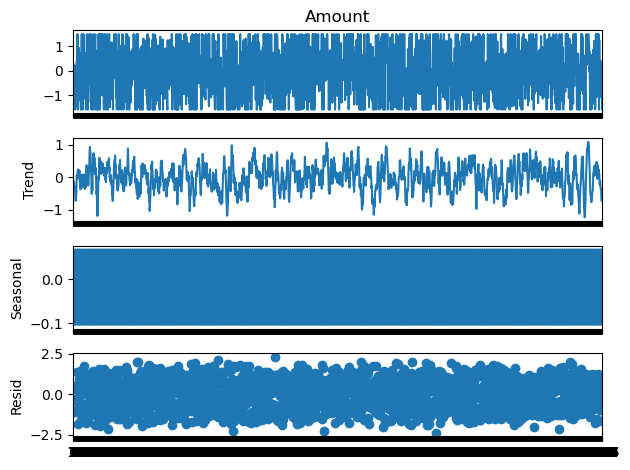

In [37]:
decomp = seasonal_decompose(df_cleaned['Amount'], period=7, model='additive')
decomp.plot()
plt.tight_layout()
plt.show()

D = 1 => ARIMA 3 1 0 / D= None => Arima 1 0 0
d indice de difference puisque la série est non stationnaire

On cherche le modèle ARIMA optimale.

In [38]:
sarima_model = pm.auto_arima(
    df_cleaned['Amount'],   # consider transforming before this
    seasonal=False,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,                    # difference once for trend
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)

print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5530.185, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5527.774, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5527.842, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5529.701, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5529.723, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5531.694, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5529.774, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.902 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1948
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2761.887
Date:                Sun, 27 Apr 2025   AIC                           5527.774
Time:                        23:06:38   BIC                           5538.923
Sample:                

In [39]:
df_cleaned.set_index('TransactionDate', inplace=True)

On passe à l'application de "Prophet" qui est une procédure de prévision de données de séries chronologiques basée sur un modèle additif où les tendances non linéaires sont ajustées à la saisonnalité annuelle, hebdomadaire et quotidienne

In [40]:
df_prophet = df_cleaned.reset_index()
df_prophet.columns = ['ds', 'y']
prophet_model = Prophet(seasonality_mode='multiplicative',
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      yearly_seasonality=False)
prophet_model.fit(df_prophet)

23:06:39 - cmdstanpy - INFO - Chain [1] start processing
23:06:39 - cmdstanpy - INFO - Chain [1] done processing


On définit cette fonction pour dégager les métriques d'évaluation de notre modèle

In [41]:
def evaluate_model(model_type='sarima'):
    tscv = TimeSeriesSplit(n_splits=3)
    metrics = []

    for train_idx, test_idx in tscv.split(df_cleaned):
        train = df_cleaned.iloc[train_idx]
        test = df_cleaned.iloc[test_idx]

        if model_type == 'sarima':
            model = pm.auto_arima(train, seasonal=True, m=7,
                                suppress_warnings=True, error_action='ignore')
            forecast = model.predict(n_periods=len(test))
            forecast = np.expm1(forecast)  # Retour à l'échelle originale
            test_values = np.expm1(test)
        else:
            train_df = train.reset_index()
            train_df.columns = ['ds', 'y']
            model = Prophet(seasonality_mode='multiplicative')
            model.fit(train_df)
            future = model.make_future_dataframe(periods=len(test), freq='D')
            forecast = model.predict(future)['yhat'].iloc[-len(test):]
            forecast = forecast.clip(lower=0)
            test_values = test.values

        # Calcul des métriques
        metrics.append({
            'MAE': mean_absolute_error(test_values, forecast),
            'MAPE': mean_absolute_percentage_error(test_values, forecast),
            'RMSE': np.sqrt(mean_squared_error(test_values, forecast)),
            'R2': r2_score(test_values, forecast)
        })

    return pd.DataFrame(metrics)

Les métriques de l'application sarima sont très mauvaises. Un MAPE de 1 indique que les prédictions sont en moyenne aussi éloignées que la valeur réelle. C’est un très mauvais signe.

In [42]:
print("\nPerformance ARIMA:")
sarima_metrics = evaluate_model('arima')
print(sarima_metrics.mean())

23:06:39 - cmdstanpy - INFO - Chain [1] start processing
23:06:39 - cmdstanpy - INFO - Chain [1] done processing



Performance ARIMA:


23:06:40 - cmdstanpy - INFO - Chain [1] start processing
23:06:40 - cmdstanpy - INFO - Chain [1] done processing
23:06:40 - cmdstanpy - INFO - Chain [1] start processing
23:06:41 - cmdstanpy - INFO - Chain [1] done processing


MAE     0.864937
MAPE    1.047922
RMSE    1.006793
R2     -0.003565
dtype: float64


De meme pour Prophet

In [43]:
print("\nPerformance Prophet:")
prophet_metrics = evaluate_model('prophet')
print(prophet_metrics.mean())

23:06:41 - cmdstanpy - INFO - Chain [1] start processing
23:06:41 - cmdstanpy - INFO - Chain [1] done processing



Performance Prophet:


23:06:41 - cmdstanpy - INFO - Chain [1] start processing
23:06:42 - cmdstanpy - INFO - Chain [1] done processing
23:06:42 - cmdstanpy - INFO - Chain [1] start processing
23:06:42 - cmdstanpy - INFO - Chain [1] done processing


MAE     0.864937
MAPE    1.047922
RMSE    1.006793
R2     -0.003565
dtype: float64


In [44]:
sarima_final = ARIMA(df_cleaned, order=sarima_model.order,
                    seasonal_order=sarima_model.seasonal_order).fit()
forecast_period = 30
sarima_forecast = sarima_final.get_forecast(steps=forecast_period)
sarima_conf_int = sarima_forecast.conf_int()

In [45]:
future = prophet_model.make_future_dataframe(periods=forecast_period)
prophet_forecast = prophet_model.predict(future)
prophet_forecast_values = prophet_forecast['yhat'].iloc[-forecast_period:]

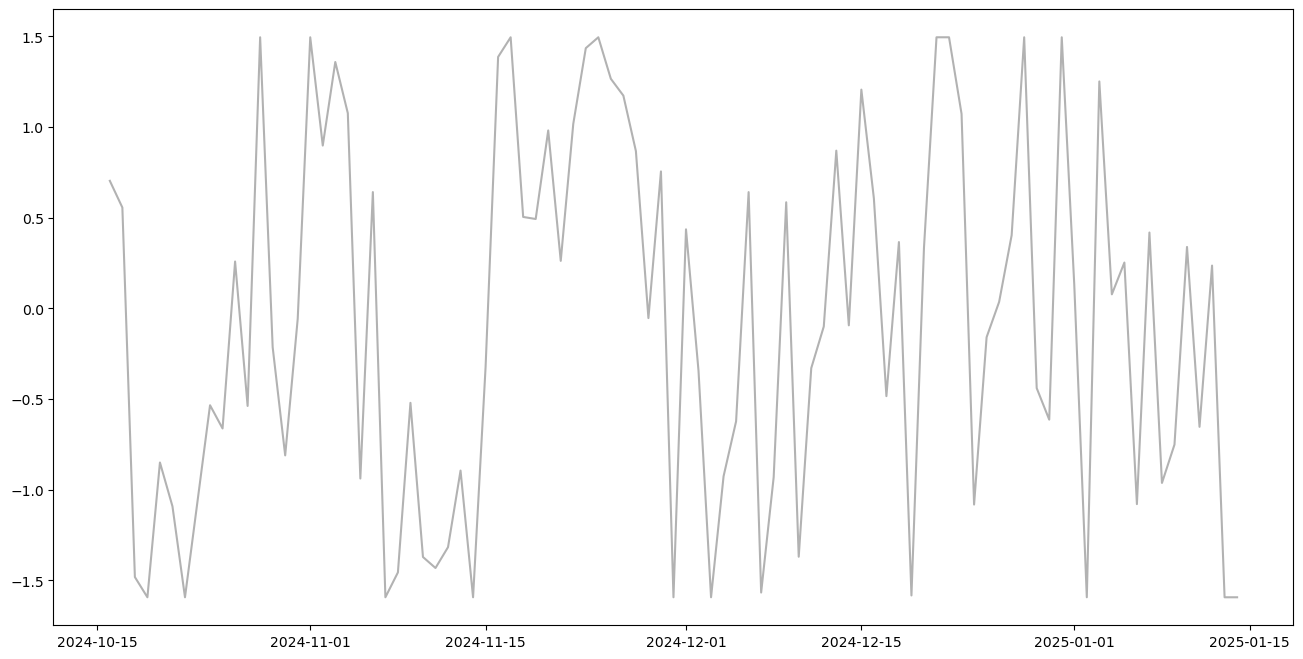

In [46]:
plt.figure(figsize=(16, 8))
plt.plot(df_cleaned[-90:], label='Données historiques', color='grey', alpha=0.6)

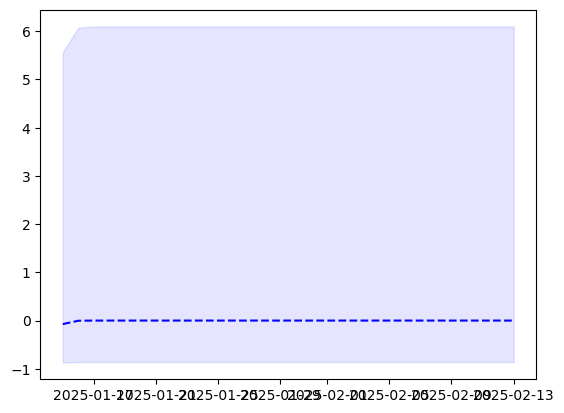

In [47]:
sarima_dates = pd.date_range(df_cleaned.index[-1], periods=forecast_period+1)[1:]
plt.plot(sarima_dates, np.expm1(sarima_forecast.predicted_mean),
        label='SARIMA', color='blue', linestyle='--')
plt.fill_between(sarima_dates,
                np.expm1(sarima_conf_int.iloc[:, 0]),
                np.expm1(sarima_conf_int.iloc[:, 1]),
                color='blue', alpha=0.1)

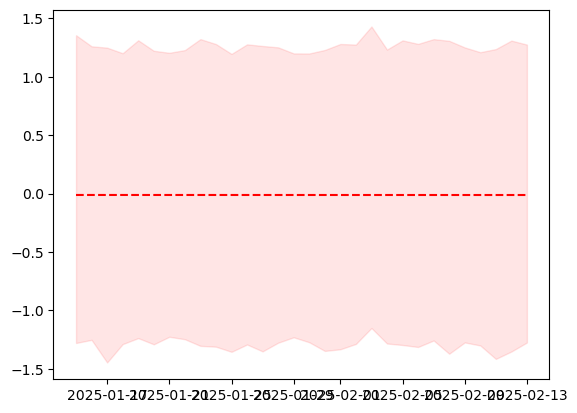

In [48]:
prophet_dates = prophet_forecast.iloc[-forecast_period:]['ds']
plt.plot(prophet_dates, prophet_forecast_values,
        label='Prophet', color='red', linestyle='--')
plt.fill_between(prophet_dates,
                prophet_forecast.iloc[-forecast_period:]['yhat_lower'],
                prophet_forecast.iloc[-forecast_period:]['yhat_upper'],
                color='red', alpha=0.1)

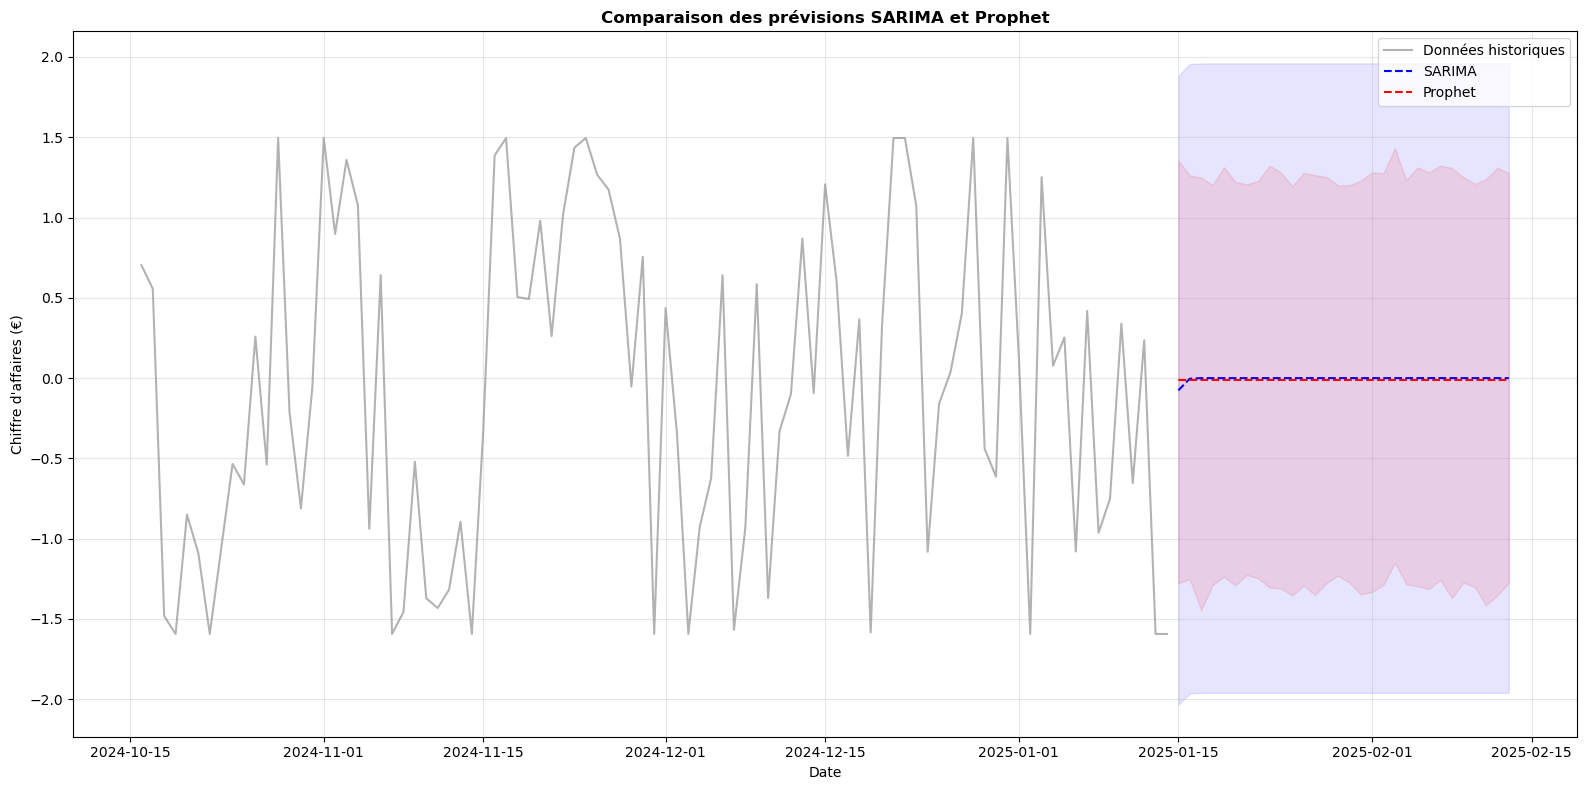

In [49]:
plt.figure(figsize=(16, 8))  # Set the figure size

# Plot historical data
plt.plot(df_cleaned[-90:].index, df_cleaned[-90:]['Amount'], label='Données historiques', color='grey', alpha=0.6)

# Plot SARIMA forecast
sarima_dates = pd.date_range(df_cleaned.index[-1], periods=forecast_period + 1, freq='D')[1:]  # Corrected freq
plt.plot(sarima_dates, sarima_forecast.predicted_mean, label='SARIMA', color='blue', linestyle='--')  # Removed np.expm1
plt.fill_between(sarima_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='blue', alpha=0.1)  # Removed np.expm1

# Plot Prophet forecast
prophet_dates = prophet_forecast['ds'].iloc[-forecast_period:]
plt.plot(prophet_dates, prophet_forecast_values, label='Prophet', color='red', linestyle='--')
plt.fill_between(prophet_dates, prophet_forecast['yhat_lower'].iloc[-forecast_period:], prophet_forecast['yhat_upper'].iloc[-forecast_period:], color='red', alpha=0.1)

# Add plot elements for clarity
plt.title('Comparaison des prévisions SARIMA et Prophet', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Chiffre d\'affaires (€)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Finally, display the plot
plt.show()

In [50]:
sarima_resid = pd.Series(sarima_final.resid, index=df_cleaned.index[1:])

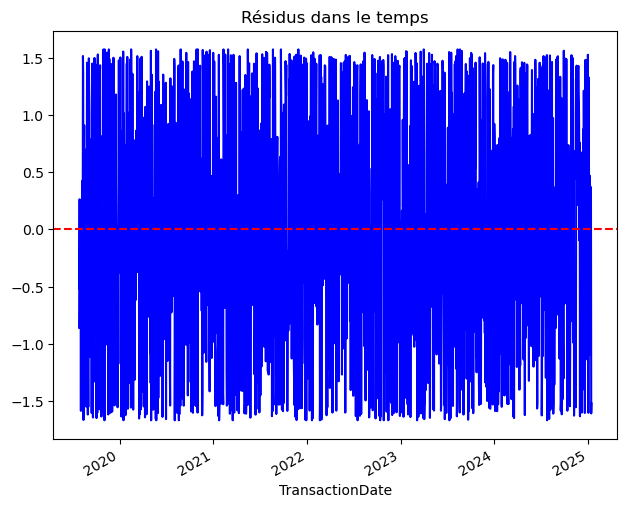

In [51]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sarima_resid.plot(title='Résidus dans le temps', color='blue')
plt.axhline(0, color='red', linestyle='--')

Text(0.5, 1.0, 'Distribution des résidus')

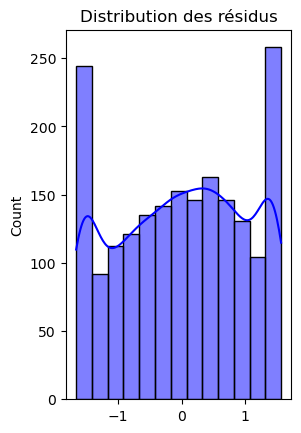

In [52]:
plt.subplot(1, 2, 2)
sns.histplot(sarima_resid, kde=True, color='blue')
plt.title('Distribution des résidus')

In [53]:
_, pval = shapiro(sarima_resid.dropna())
print(f"Test de normalité (Shapiro-Wilk) p-value: {pval:.4f}")

Test de normalité (Shapiro-Wilk) p-value: 0.0000
